In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from typing import Generator, Optional, Tuple
from utils import build_sequences, load_txt_file

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent.parent))

# Import custom modules
from src.models.data_loader import DataLoader, Split
from src.models import TrainingArguments, LabeledData
from src.core.utils import data_analysis, context_manager
from src import Tensor, loss_functions, optimizers, metrics
from src.architectures.transformer import Tokenizer, DecoderTransformer
from src.architectures.transformer.config import TransformerConfig, DeepSeekTransformerBlockConfig, LatentAttentionConfig, MOEConfig, MLPConfig

### Constants and hyperparameters

In [2]:
# Constants
dataset_path = os.path.join(os.getcwd(), 'dataset', 'shakespeare.txt')
tokenizer_path = os.path.join(os.getcwd(), 'checkpoints', 'tokenizer_shakespeare.json')
model_path = os.path.join(os.getcwd(), 'checkpoints', 'language_model_shakespeare')

In [3]:
# Hyperparameters
dropout = 0.2 # The dropout rate
n_epochs = 30 # The number of epochs to train the model for
max_steps_per_epoch = 100 # Number of random training steps per epoch
max_eval_steps_per_epoch = 50 # Number of validation/test steps for faster evaluation
max_test_samples = 256 # Number of test samples for faster evaluation
train_test_split_pct = 0.1 # 90% of the data will be used for training, 10% for testing
train_valid_split_pct = 0.1 # 90% of the training data will be used for training, 10% for validation
batch_size = 8 # The number of samples to use for each batch
grad_accumulation_steps = 4 # The number of steps to accumulate gradients before updating the model
max_sequence_length = 256 # The size of the sequence length (the context window)
learning_rate = 1e-3 # The learning rate for the optimizer
weight_decay = 0.01 # The weight decay for the optimizer
seed = 42 # Random seed for reproducibility
n_embed = 384 # The size of the token embeddings (the dimensionality of the embeddings)
n_attention_heads = 8 # The number of attention heads in the multi-head attention mechanism
n_decoder_blocks = 8 # The number of transformer decoder blocks in the model

### Data loading

In [4]:
# Instantiate the tokenizer
tokenizer = Tokenizer()

# Load the state of the tokenizer
tokenizer.load(tokenizer_path)

# Extract the vocabulary size
vocab_size = tokenizer.get_vocab_size()

In [5]:
# Load the text file
text = load_txt_file(dataset_path)

# Encode the text using the tokenizer
encoded_text = tokenizer.encode(text)

# Convert the data to a tensor
data = np.array(encoded_text)

### Data preprocessing

In [6]:
# Split the token stream first to avoid leakage across train/valid/test
n_tokens = len(data)
test_tokens = max(1, int(n_tokens * train_test_split_pct))
train_valid_tokens = n_tokens - test_tokens
valid_tokens = max(1, int(train_valid_tokens * train_valid_split_pct))
train_tokens = train_valid_tokens - valid_tokens

# Extract the token splits
tokens_train = data[:train_tokens]
tokens_valid = data[train_tokens:train_tokens + valid_tokens]
tokens_test = data[train_tokens + valid_tokens:]

# Build the full sequence datasets for each split
X_train_data, y_train_data = build_sequences(tokens_train, max_sequence_length)
X_valid_data, y_valid_data = build_sequences(tokens_valid, max_sequence_length)
X_test_data, y_test_data = build_sequences(tokens_test, max_sequence_length)

# Convert the data to Tensors
X_train = Tensor(X_train_data.astype(np.int32))
y_train = Tensor(y_train_data.astype(np.int32))
X_valid = Tensor(X_valid_data.astype(np.int32))
y_valid = Tensor(y_valid_data.astype(np.int32))
X_test = Tensor(X_test_data.astype(np.int32))
y_test = Tensor(y_test_data.astype(np.int32))

In [7]:
# Print the dataset information
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Training set: (468459, 256) (468459, 256)
Validation set: (51823, 256) (51823, 256)
Testing set: (57610, 256) (57610, 256)


### Building the model

In [8]:
# Create the language model
language_model = DecoderTransformer(
    name = "Language Model",
    config = TransformerConfig(
        input_dim = vocab_size, # The size of the input vocabulary
        embed_dim = n_embed, # The size of the token embeddings
        num_blocks = n_decoder_blocks, # The number of transformer blocks
        max_sequence_length = max_sequence_length, # The length of the input sequences
        return_sequence = True, # Return the full sequence output
        use_cache = True, # Use caching for faster decoding during inference
        input_type = "discrete", # Discrete input type for token IDs
        positional_encoding_type = "learned", # Positional encoding type
        block_config = DeepSeekTransformerBlockConfig(
            attention_config = LatentAttentionConfig(
                num_heads = 4, # Number of attention heads
                dropout = 0.1, # Dropout rate
                causal = True, # Causal attention
                q_lora_rank = 64, # LoRA rank for query
                qk_lora_rank = 64, # LoRA rank for query-key
                qk_nope_head_dim = 16, # NoPE head dimension for query-key
                qk_rope_head_dim = 16, # RoPE head dimension for query-key
                kv_lora_rank = 32, # LoRA rank for key-value
                v_head_dim = 32, # Head dimension for value
                softmax_scale = 1.0 # Softmax scaling factor
            ),
            ffn_config = MOEConfig(
                top_k = 2, # Top-k experts to use
                n_groups = 1, # Number of expert groups
                top_k_groups = 1, # Number of top-k groups
                score_function = "softmax", # Scoring function for routing
                route_scale = 1.0, # Scaling factor for routing scores
                n_routed_experts = 4, # Number of routed experts
                n_shared_experts = 2, # Number of shared experts
                mlp_config = MLPConfig(
                    dropout = 0.1, # Dropout rate
                    hidden_dim = 256 # Hidden dimension
                )
            )
        )
    )
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Initialize the loss function
loss_fn = loss_functions.CrossEntropy(from_logits=True)

### Initializing the model

In [9]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    language_model.eval()
    
    # Call the model with a batch of data to initialize it
    language_model(X_train[:batch_size])

In [10]:
# Display the model summary in tree format.
# This is useful since the whole model is composed of submodules,
# therefore, the model summary will be displayed recursively
language_model.summary(recursive=True)

Language Model (DecoderTransformer) [output_shape=(8, 256, 1024), params=15953440]
└── language_model.modules (ModuleList) [output_shape=(8, 256, 1024), params=15953440]
    └── module_list.0 (Decoder) [output_shape=(8, 256, 1024), params=15953440]
        ├── decoder.input_proj (Embedding) [output_shape=(8, 256, 384), params=393216]
        ├── decoder.positional_encoding (Embedding) [output_shape=(256, 384), params=98304]
        ├── decoder.decoder_blocks (ModuleList) [output_shape=?, params=15066912]
        │   ├── module_list.0 (Block) [output_shape=(8, 256, 384), params=1883364]
        │   │   ├── block.mla (SelfMultiHeadLatentAttention) [output_shape=(8, 256, 384), params=106592]
        │   │   │   ├── self_multi_head_latent_attention.wq_a (Dense) [output_shape=(8, 256, 64), params=24576]
        │   │   │   ├── self_multi_head_latent_attention.q_norm (RMSNorm) [output_shape=(8, 256, 64), params=64]
        │   │   │   ├── self_multi_head_latent_attention.wq_b (Dense) [output

### Training the model

In [11]:
# Define the data loader for language model training
class LanguageModelDataLoader(DataLoader):
    """
    DataLoader with random train sampling and sequential validation batches.
    """

    def __init__(
        self,
        train_data: LabeledData,
        valid_data: Optional[LabeledData] = None,
        max_train_steps_per_epoch: int = 100,
        max_eval_steps_per_epoch: int = 25,
        seed: int = 42
    ) -> None:
        """
        Initialize the data loader.

        Args:
        - train_data (LabeledData): The training data.
        - valid_data (Optional[LabeledData]): The validation data. If None, the validation split will be empty.
        - max_train_steps_per_epoch (int): The maximum number of training steps to take per epoch. 
            This is used to limit the number of random batches sampled during training.
        - max_eval_steps_per_epoch (int): The maximum number of evaluation steps to take per epoch for validation and testing. 
            This is used to limit the number of batches sampled during evaluation for faster evaluation.
        - seed (int): The random seed for reproducibility when sampling batches.
        """

        # Call the parent constructor to initialize the data splits
        super().__init__(train_data=train_data, valid_data=valid_data)

        # Store the maximum number of steps per epoch for training and evaluation
        self.max_train_steps_per_epoch = max_train_steps_per_epoch
        self.max_eval_steps_per_epoch = max_eval_steps_per_epoch

        # Initialize the random number generator for sampling batches
        self._rng = np.random.default_rng(seed)


    def get_batch(self, split: Split, batch_size: int) -> Generator[Tuple[Tuple[Tensor, ...], Tensor], None, None]:
        """
        Get a batch of data for the specified split.
        
        Args:
        - split (Split): The data split to get the batch from (train, valid, or test).
        - batch_size (int): The number of samples to include in the batch.
        
        Yields:
        - Tuple[Tuple[Tensor, ...], Tensor]: A tuple containing the input tensors and the target tensor for the batch.
        """

        # Get the data for the specified split
        data = self._get_data_split(split)

        # Determine the number of steps to take based on the split
        num_steps = self.num_batches(split=split)

        # Extract the inputs and targets from the data
        data_inputs = data.input_tuple
        data_targets = data.target

        # Get the number of samples in the dataset
        n_samples = data_inputs[0].shape[0]

        # Iterate for the specified number of steps and yield batches of data
        for _ in range(num_steps):
            # Sample random indices for the batch
            batch_indices = self._rng.integers(0, n_samples, size=batch_size)

            # Create the batch of input tensors and target tensor using the sampled indices
            x_batch = tuple(tensor[batch_indices] for tensor in data_inputs)
            y_batch = data_targets[batch_indices]

            # Yield the batch of input tensors and target tensor
            yield x_batch, y_batch


    def num_batches(self, split: Split, *args, **kwargs) -> int:
        """
        Get the number of batches to take for the specified split.
        
        Args:
        - split (Split): The data split to get the number of batches for (train, valid, or test).
        
        Returns:
        - int: The number of batches to take for the specified split.
        """

        # Determine the number of steps to take based on the split
        if split == Split.TRAIN:
            return self.max_train_steps_per_epoch
        if split == Split.VALID:
            return self.max_eval_steps_per_epoch

In [12]:
# Create the training arguments
train_arguments = TrainingArguments(
    data_loader = LanguageModelDataLoader(
        train_data = LabeledData(input={'x': X_train}, target=y_train),
        valid_data = LabeledData(input={'x': X_valid}, target=y_valid),
        max_train_steps_per_epoch = max_steps_per_epoch,
        max_eval_steps_per_epoch = max_eval_steps_per_epoch,
        seed = seed
    ),
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_batch_size = batch_size,
    num_epochs = n_epochs,
    gradient_accumulation_steps = grad_accumulation_steps
)

# Train the model
history = language_model.fit(train_arguments)

Epoch 1/30 --> loss: 4.8262 | val_loss: 4.0339                                                                                                       
Epoch 2/30 --> loss: 3.722 | val_loss: 3.692                                                                                                         
Epoch 3/30 --> loss: 3.4481 | val_loss: 3.4712                                                                                                       
Epoch 4/30 --> loss: 3.1308 | val_loss: 3.081                                                                                                        
Epoch 5/30 --> loss: 2.6888 | val_loss: 2.4476                                                                                                       
Epoch 6/30 --> loss: 2.0551 | val_loss: 1.9516                                                                                                       
Epoch 7/30 --> loss: 1.7911 | val_loss: 1.8354                                                      

In [13]:
# Save the model 
language_model.save(model_path)

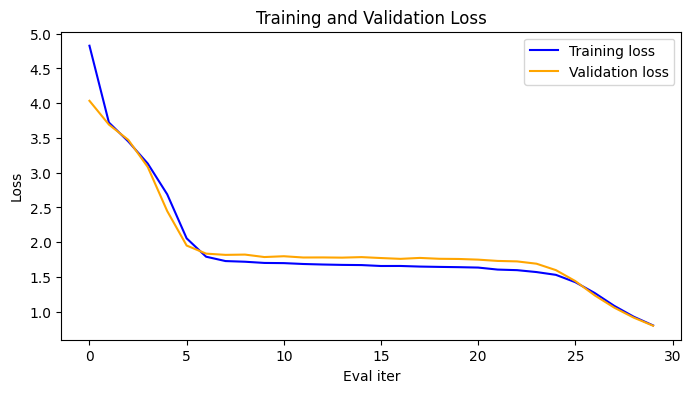

In [14]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = language_model.history["loss"], 
    valid_loss = language_model.history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Eval iter",
    ylabel = "Loss"
)

### Evaluation

In [15]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    language_model.eval()
    
    # Compute the predictions
    predictions_out = language_model(X_test[:max_test_samples], batch_size=batch_size, verbose=True)

# Apply the argmax function to the predictions
predictions = Tensor(np.argmax(predictions_out.output.to_numpy(), axis=-1), dtype=np.int8)

Processing batch 32/32 - 318.7 ms/stepp

In [16]:
# Compute the accuracy
accuracy = metrics.accuracy(y_test[:max_test_samples, -1], predictions[:, -1])

# Print the accuracy
print(f"Accuracy: {accuracy.data:.2f}")

Accuracy: 0.18


### Inference

In [17]:
# Generate some text context from the trained model
context = Tensor(np.zeros((1, 1), dtype=np.int32))

# Iterate over the tokens generated by the transformer
for token in language_model.autoregressive_generation(x=context, num_steps=200, stream=True, do_sample=True):
    # Decode the token - use .item() to extract the scalar value
    decoded_token = tokenizer.decode([int(token.data.item())])

    # Print the decoded token
    print(decoded_token, end='', flush=True)

 forble,
O, wake may, a orning bort risets:
When you.
Thenermilight fair cute seety triefs but can give to, afive o lov o ligum Somaltunnerve to he the hear himself ender queen chamble send me.
Hence
EYetered truth.

Westy, much canyer'd the come?

No my of me;
Thenyeto thy, send.

Pock trieveire cry; beenough, bire hadgry haven is do and, ears sasp all a could ime me, see p